# Introduction

SmolVLM fine-tuning notebook. Full fine-tuning of the model.

## Install Dependencies

In [1]:
# !pip install -q transformers trl==0.12.1 datasets bitsandbytes peft accelerate
# transformers==4.46.3, trl==0.12.1, datasets==3.1.0, bitsandbytes==0.45.0, peft==0.13.2, accelerate==1.1.1

In [2]:
# !pip install -q flash-attn --no-build-isolation

In [3]:
import glob
import pandas as pd
import os
import torch
import gc
import time
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from datasets import Dataset
from PIL import Image
from transformers import AutoModelForVision2Seq, AutoProcessor
from transformers import BitsAndBytesConfig
from peft import LoraConfig, get_peft_model
from trl import SFTConfig, SFTTrainer

In [4]:
os.environ['TOKENIZERS_PARALLELISM'] = 'false'

## Load Dataset

In [5]:
system_message = """You are a vision language model expert at creating at OCR of receipts, invoices, and forms."""

In [6]:
def format_data(samples):
    # print(samples)
    data_samples = []

    for i in range(len(samples['image_paths'])):
        # image = Image.open(samples['image_paths'][i]).convert('RGB')
        image = samples['image_paths'][i]
        query = 'OCR this image accurately.'
        label = samples['text_paths'][i]
        
        data_samples.append([
            {
                'role': 'system',
                'content': [
                    {
                        'type': 'text',
                        'text': system_message
                    }
                ],
            },
            {
                'role': 'user',
                'content': [
                    {
                        'type': 'image',
                        'image': image,
                    },
                    {
                        'type': 'text',
                        'text': query,
                    }
                ],
            },
            {
                'role': 'assistant',
                'content': [
                    {
                        'type': 'text',
                        'text': label
                    }
                ],
            },
        ])
    return {'data': data_samples}

In [7]:
train_text_files = glob.glob('../input/qwen2_5_vl_3b_annots/train_annots/*.txt')
test_text_files = glob.glob('../input/qwen2_5_vl_3b_annots/test_annots/*.txt')

train_text_files.sort()
test_text_files.sort()

In [8]:
def prepare_img_txt_list(text_files, split='train'):
    all_images, all_texts = [], []
    
    for text_file in text_files:
        text = open(text_file).read()
    
        if len(text) > 200:
            text_file_name = text_file.split(os.path.sep)[-1].split('.txt')[0]
    
            image_file_name = os.path.join(f'../input/sroie_v2/SROIE2019/{split}/img/', text_file_name+'.jpg')
    
            all_images.append(image_file_name)
            all_texts.append(text)

    return all_images, all_texts

In [9]:
all_train_images, all_train_texts = prepare_img_txt_list(train_text_files, split='train')
all_test_images, all_test_texts = prepare_img_txt_list(test_text_files, split='test')

In [10]:
print(len(all_train_images), len(all_train_texts))
print(len(all_test_images), len(all_test_texts))

625 625
347 347


In [11]:
train_df = pd.DataFrame(
    {
        'image_paths': all_train_images,
        'text_paths': all_train_texts
    }
)

test_df = pd.DataFrame(
    {
        'image_paths': all_test_images,
        'text_paths': all_test_texts
    }
)

In [12]:
train_from_df = Dataset.from_pandas(train_df)
test_from_df = Dataset.from_pandas(test_df)

In [13]:
print(train_from_df)
print(test_from_df)

Dataset({
    features: ['image_paths', 'text_paths'],
    num_rows: 625
})
Dataset({
    features: ['image_paths', 'text_paths'],
    num_rows: 347
})


In [14]:
# train_from_df = train_from_df.with_format('numpy')
# test_from_df = test_from_df.with_format('numpy')

In [15]:
train_dataset = train_from_df.map(
    format_data, 
    batched=True, 
    batch_size=128,
    num_proc=8,
    remove_columns=train_from_df.column_names
)
test_dataset = test_from_df.map(
    format_data, 
    batched=True, 
    batch_size=128,
    num_proc=8,
    remove_columns=test_from_df.column_names
)

Map (num_proc=8):   0%|          | 0/625 [00:00<?, ? examples/s]

Map (num_proc=8):   0%|          | 0/347 [00:00<?, ? examples/s]

In [16]:
print(train_dataset['data'][2])

[{'content': [{'image': None, 'text': 'You are a vision language model expert at creating at OCR of receipts, invoices, and forms.', 'type': 'text'}], 'role': 'system'}, {'content': [{'image': '../input/sroie_v2/SROIE2019/train/img/X00016469620.jpg', 'text': None, 'type': 'image'}, {'image': None, 'text': 'OCR this image accurately.', 'type': 'text'}], 'role': 'user'}, {'content': [{'image': None, 'text': 'tan woon yann\nMR D.I.Y. (JOHOR) SDN BHD\n(CO.REG.:933109-X)\nLOT 1851-A & 1851-B, JALAN KPB 6,\nKAWASAN PERINDUSTRIAN BALAKONG,\n43300 SERI KEMBANGAN, SELANGOR\n(MR DIY TESCO TERBAU)\n-INVOCIE-\nCHOPPING BOARD 35.5x25.5CM 803M#\nEZ10HD05 - 24\n8970669\n1 X 19.00 19.00\nAIR PRESSURE SPRAYER SX-575-1 1.5L\nHC03-7 - 15\n9066468\n1 X 8.02 8.02\nWAXCO WINDSHILED CLEANER 120ML\nWA14-3A - 48\n9557031100236\n1 X 3.02 3.02\nBOPP TAPE 48MM*100M CLEAR\nFZ-04 - 36\n6935818350846\n1 X 3.88 3.88\nItem(s): 4 Qty(s): 4\nTOTAL\nRM 33.92\nROUNDING ADJUSTMENT\n-RM 0.02\nTOTAL ROUNDED\nRM 33.90\nCASH\n

## Load Model

In [17]:
model_id = 'HuggingFaceTB/SmolVLM-256M-Instruct'

In [18]:
model = AutoModelForVision2Seq.from_pretrained(
    model_id,
    device_map='auto',
    torch_dtype=torch.bfloat16,
    _attn_implementation='flash_attention_2', # Use `flash_attention_2` on Ampere GPUs and above and `eager` on older GPUs.
    # _attn_implementation='eager', # Use `flash_attention_2` on Ampere GPUs and above and `eager` on older GPUs.
)

processor = AutoProcessor.from_pretrained(model_id)

In [19]:
def generate_text_from_sample(model, processor, sample, max_new_tokens=1024, device='cuda'):
    # Prepare the text input by applying the chat template
    text_input = processor.apply_chat_template(
        sample['data'][1:2],  # Use the sample without the system message
        add_generation_prompt=True
    )

    image_inputs = []
    image = Image.open(sample['data'][1]['content'][0]['image']).convert('RGB')
    if image.mode != 'RGB':
        image = image.convert('RGB')
    image_inputs.append([image])

    # Prepare the inputs for the model
    model_inputs = processor(
        #text=[text_input],
        text=text_input,
        images=image_inputs,
        return_tensors='pt',
    ).to(device)  # Move inputs to the specified device

    # Generate text with the model
    generated_ids = model.generate(**model_inputs, max_new_tokens=max_new_tokens)

    # Trim the generated ids to remove the input ids
    trimmed_generated_ids = [
        out_ids[len(in_ids):] for in_ids, out_ids in zip(model_inputs.input_ids, generated_ids)
    ]

    # Decode the output text
    output_text = processor.batch_decode(
        trimmed_generated_ids,
        skip_special_tokens=True,
        clean_up_tokenization_spaces=False
    )

    return output_text[0]  # Return the first decoded output text

In [20]:
output = generate_text_from_sample(model, processor, train_dataset[1])
print(output)

 The image is a receipt from a store called "Tan Woon Yann" located at 81100 Johor, Johor. The receipt is dated 19/10/2018 and includes the following details:

- **Store Name**: Tan Woon Yann
- **Address**: 81100 Johor, Johor
- **Phone Number**: 07-3507405
- **Fax Number**: 07-358160
- **Telephone Number**: 07-358160
- **Recipient's Name**: INDAH GIFT & HOME DECO
- **Date**: 19/10/2018
- **Date of Receipt**: 19/10/2018
- **Date of Receipt**: 19/10/2018
- **Recipient's Name**: TAMAN JOHOR JAYA
- **Date**: 19/10/2018
- **Date of Receipt**: 19/10/2018
- **Recipient's Name**: TAMAN JOHOR BAHIRU JOHOR
- **Date**: 19/10/2018
- **Date of Receipt**: 19/10/2018
- **Recipient's Name**: TAMAN JOHOR BABU RAHUBUR JOHOR
- **Date**: 19/10/2018
- **Date of Receipt**: 19/10/2018
- **Recipient's Name**: TAMAN JOHOR BABU RAHUBUR
- **Date**: 19/10/2018
- **Date of Receipt**: 19/10/2018
- **Recipient's Name**: TAMAN JOHOR BABU RAHUBUR
- **Date**: 19/10/2018
- **Date of Receipt**: 19/10/2018
- **Recipient's

Clear GPU memory before training.

In [21]:
def clear_memory():
    # Delete variables if they exist in the current global scope
    if 'inputs' in globals(): del globals()['inputs']
    if 'model' in globals(): del globals()['model']
    if 'processor' in globals(): del globals()['processor']
    if 'trainer' in globals(): del globals()['trainer']
    if 'peft_model' in globals(): del globals()['peft_model']
    if 'bnb_config' in globals(): del globals()['bnb_config']
    time.sleep(2)

    # Garbage collection and clearing CUDA memory
    gc.collect()
    time.sleep(2)
    torch.cuda.empty_cache()
    torch.cuda.synchronize()
    time.sleep(2)
    gc.collect()
    time.sleep(2)

    print(f'GPU allocated memory: {torch.cuda.memory_allocated() / 1024**3:.2f} GB')
    print(f'GPU reserved memory: {torch.cuda.memory_reserved() / 1024**3:.2f} GB')

clear_memory()

GPU allocated memory: 0.01 GB
GPU reserved memory: 0.05 GB


## Fine-Tune the Model using TRL


In [22]:
# Load model and tokenizer
model = AutoModelForVision2Seq.from_pretrained(
    model_id,
    device_map='auto',
    torch_dtype=torch.bfloat16,
    _attn_implementation='flash_attention_2', # Use `flash_attention_2` on Ampere GPUs and above and `eager` on older GPUs.
    # _attn_implementation='eager', # Use `flash_attention_2` on Ampere GPUs and above and `eager` on older GPUs.
)
processor = AutoProcessor.from_pretrained(model_id)

In [23]:
def print_trainable_parameters(model):
    """
    Prints the number of trainable parameters in the model.
    """
    trainable_params = 0
    all_param = 0
    for _, param in model.named_parameters():
        all_param += param.numel()
        if param.requires_grad:
            trainable_params += param.numel()
    print(
        f"trainable params: {trainable_params} || all params: {all_param} || trainable%: {100 * trainable_params / all_param:.2f}"
    )

In [24]:
print_trainable_parameters(model)

trainable params: 256484928 || all params: 256484928 || trainable%: 100.00


In [25]:
output_dir = 'trained_models/full_ft/smolvlm256m_fullft_qwen2_5_vl_3b_gt_20250503'

In [26]:
# Configure training arguments using SFTConfig
training_args = SFTConfig(
    output_dir=output_dir,
    logging_dir=output_dir,
    num_train_epochs=10,
    per_device_train_batch_size=2,
    per_device_eval_batch_size=2,
    gradient_accumulation_steps=4,
    warmup_steps=50,
    learning_rate=1e-4,
    weight_decay=0.01,
    logging_steps=100,
    eval_steps=100,
    save_steps=100,
    logging_strategy='steps',
    eval_strategy='steps',
    save_strategy='steps',
    save_total_limit=1,
    optim='adamw_torch_fused',
    bf16=True,
    report_to='tensorboard',
    remove_unused_columns=False,
    gradient_checkpointing=True,
    dataloader_num_workers=4,
    dataset_text_field='',
    dataset_kwargs={'skip_prepare_dataset': True},
    load_best_model_at_end=True
)

In [27]:
image_token_id = processor.tokenizer.additional_special_tokens_ids[
            processor.tokenizer.additional_special_tokens.index('<image>')]

def collate_fn(examples):
    texts = [processor.apply_chat_template(example, tokenize=False) for example in examples]

    image_inputs = []
    for example in examples:
      image = Image.open(example[1]['content'][0]['image']).convert('RGB')
      if image.mode != 'RGB':
          image = image.convert('RGB')
      image_inputs.append([image])

    batch = processor(text=texts, images=image_inputs, return_tensors='pt', padding=True)
    labels = batch['input_ids'].clone()
    labels[labels == processor.tokenizer.pad_token_id] = -100  # Mask padding tokens in labels
    labels[labels == image_token_id] = -100  # Mask image token IDs in labels

    batch['labels'] = labels

    return batch

In [28]:
trainer = SFTTrainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset['data'],
    eval_dataset=test_dataset['data'],
    data_collator=collate_fn,
    tokenizer=processor.tokenizer
)

/home/sovit/miniconda3/envs/receipt_ocr/lib/python3.11/site-packages/trl/trainer/sft_trainer.py:309: UserWarning: You didn't pass a `max_seq_length` argument to the SFTTrainer, this will default to 1024
  warnings.warn(


In [29]:
trainer.can_return_loss = True

In [30]:
trainer.train()

`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


Step,Training Loss,Validation Loss
100,0.595700,0.424379
200,0.314100,0.368174
300,0.231000,0.337320
400,0.166100,0.340988
500,0.117000,0.346360
600,0.072700,0.371530
700,0.056300,0.385292


TrainOutput(global_step=780, training_loss=0.2033403176527757, metrics={'train_runtime': 2617.27, 'train_samples_per_second': 2.388, 'train_steps_per_second': 0.298, 'total_flos': 1.0693737026923392e+16, 'train_loss': 0.2033403176527757, 'epoch': 9.881789137380192})

In [31]:
trainer.save_model(training_args.output_dir)
processor.save_pretrained(training_args.output_dir)

['trained_models/full_ft/smolvlm256m_fullft_qwen2_5_vl_3b_gt_20250503/processor_config.json']

In [32]:
# trainer.push_to_hub()
# processor.push_to_hub('smolvlm256m_fullft_qwen2_5_vl_3b_gt_20250501')

## Testing the Fine-Tuned Model

In [33]:
clear_memory()

GPU allocated memory: 0.02 GB
GPU reserved memory: 0.21 GB


In [34]:
model_path = 'trained_models/full_ft/smolvlm256m_fullft_qwen2_5_vl_3b_gt_20250503/'
model = AutoModelForVision2Seq.from_pretrained(
    model_path,
    device_map='auto',
    torch_dtype=torch.bfloat16,
    _attn_implementation='flash_attention_2', # Use `flash_attention_2` on Ampere GPUs and above and `eager` on older GPUs.
    # _attn_implementation='eager', # Use `flash_attention_2` on Ampere GPUs and above and `eager` on older GPUs.
)

processor = AutoProcessor.from_pretrained(model_path)

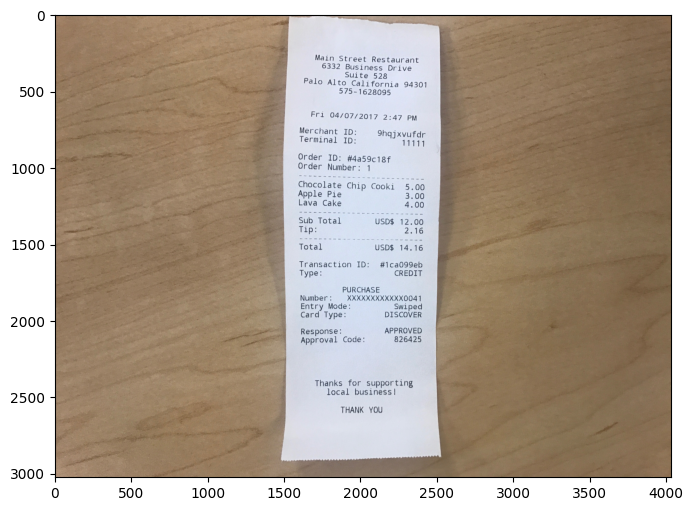

In [35]:
test_image = Image.open('inference_data/image_1.jpeg').convert('RGB')

plt.figure(figsize=(9, 6))
plt.imshow(test_image)

In [36]:
def test(model, processor, image, max_new_tokens=1024, device='cuda'):
    messages = [
        {
            'role': 'user',
            'content': [
                {'type': 'image'},
                {'type': 'text', 'text': 'OCR this image accurately'}
            ]
        },
    ]
    
    # Prepare the text input by applying the chat template
    text_input = processor.apply_chat_template(
        messages,  # Use the sample without the system message
        add_generation_prompt=True
    )

    image_inputs = []
    if image.mode != 'RGB':
        image = image.convert('RGB')
        
    image_inputs.append([image])

    # Prepare the inputs for the model
    model_inputs = processor(
        #text=[text_input],
        text=text_input,
        images=image_inputs,
        return_tensors='pt',
    ).to(device)  # Move inputs to the specified device

    # Generate text with the model
    generated_ids = model.generate(**model_inputs, max_new_tokens=max_new_tokens)

    # Trim the generated ids to remove the input ids
    trimmed_generated_ids = [
        out_ids[len(in_ids):] for in_ids, out_ids in zip(model_inputs.input_ids, generated_ids)
    ]

    # Decode the output text
    output_text = processor.batch_decode(
        trimmed_generated_ids,
        skip_special_tokens=True,
        clean_up_tokenization_spaces=False
    )

    return output_text[0]  # Return the first decoded output text

In [37]:
output = test(model, processor, test_image)
print(output)

 Main Street Restaurant
6332 Business Drive
Suite 528
Palo Alto California 94301
575-1628095
Fri 04/07/2017 2:47 PM
Merchant ID: 9qhjxvfdr
Terminal ID: 9qhjxvfdr
Order ID: #459c18f
Order Number: 1
Chocolate Chip Cookie 5.00
Applicable Pie 3.00
Lava Cake 4.00
Sub Total US$ 12.00
Tip: 2.16
Total US$ 14.16
Transaction ID: #1a099eb
Type: CREDIT
Number: PURCHASE
Entry Mode: SWIPED
Card Type: DISCOVER
Response: APPROVED
Approval Code: 8266425
Thanks for supporting
Local business!
THANK YOU
